In [1]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Set GPU Index to use
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0 
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def cv_initialize(model, loader, ratio, device):
    
    def initialize_hook(module, input, output):
        if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):
            """KDLSQ-BERT ACT Quant init Method
            Ref: https://arxiv.org/abs/2101.05938
            """
            if not isinstance(input, torch.Tensor):
                input = input[0]
        
            n = torch.numel(input)
            input_sorted, index = torch.sort(input.reshape(-1), descending=False)
            
            index_min = torch.round(ratio * n / 2)
            index_max = n - index_min
            
            s_init = (input_sorted[int(index_min)].to(device), input_sorted[int(index_max)].to(device))
            
            # MATPLOT
            
            fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(16, 4))            
            
            sns.histplot(data=input.reshape(-1).detach().cpu().numpy(), kde = True, bins=100, ax=ax1)
            sns.rugplot(data=input.reshape(-1).detach().cpu().numpy(), ax=ax1)
            sns.histplot(data=module.weight.reshape(-1).detach().cpu().numpy(), kde = True, bins=100, ax=ax2)
            sns.rugplot(data=module.weight.reshape(-1).detach().cpu().numpy(), ax=ax2)
            sns.histplot(data=output.reshape(-1).detach().cpu().numpy(), kde = True, bins=100, ax=ax3)
            sns.rugplot(data=output.reshape(-1).detach().cpu().numpy(), ax=ax3)
            # fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 4))            
            
            # sns.distplot(input.reshape(-1).detach().cpu().numpy() , hist = True, rug = True, kde = True, bins=100, norm_hist=False, kde_kws=dict(linewidth=0.5), rug_kws=dict(linewidth=0.5), ax=ax1)
            # sns.distplot(output.reshape(-1).detach().cpu().numpy() , hist = True, rug = True, kde = True, bins=100, norm_hist=False, kde_kws=dict(linewidth=0.5), rug_kws=dict(linewidth=0.5), ax=ax2)
            # # plt.axvline(x=s_init[0].detach().cpu().numpy(), color='r', linestyle='--')
            # # plt.axvline(x=s_init[1].detach().cpu().numpy(), color='r', linestyle='--')

            ax1.set_xlabel("Input Activation")
            # ax2.set_xlabel("Output Activation")
            ax2.set_xlabel("Module Weight")
            ax3.set_xlabel("Output Activation")
            
            ax1.set_ylabel("Density")
            ax2.set_ylabel("Density")
            ax3.set_ylabel("Density")

            ax1.set_title(f"{module.name} Input ACT histogram")
            # ax2.set_title(f"{module.name} Output ACT histogram")
            ax2.set_title(f"{module.name} Weight histogram")
            ax3.set_title(f"{module.name} Output ACT histogram")
            # plt.savefig(f"plt_storage/hook_inputs/sst-2-fp/{module.name}.png")
            plt.show()
            plt.close(fig)
            # module.clip_initialize(s_init)
            # logger.info(f"{module} : min {s_init[0].item()} max {s_init[1].item()}") 

    
    hooks = []

    for name, module in model.named_modules():
        hook = module.register_forward_hook(initialize_hook)
        hooks.append(hook)
    
    model.train()
    model.to(device)
    
    for step, batch in enumerate(loader):
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch        
        with torch.no_grad():
            student_logits, student_atts, student_reps, student_probs, student_values = model(input_ids, segment_ids, input_mask, teacher_probs=None)
        break
    
    for hook in hooks:
        hook.remove()

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            #vocab[token] = index
            vocab[index] = token
            index += 1
    return vocab

def attention_pattern(model, loader, device):
    
    def initialize_hook(module, input, output):
        if isinstance(module, BertSelfAttention):
            
            attn_mask = input[1]
            attention_output = output[-2]
            
            seq_length = (attn_mask == 0).sum()
            
            print(attention_output[0,:,:seq_length,seq_length-1].mean().item())
            

    hooks = []

    for name, module in model.named_modules():
        hook = module.register_forward_hook(initialize_hook)
        hooks.append(hook)
    
    model.eval()
    model.to(device)
    
    for step, batch in enumerate(loader):
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch        
        with torch.no_grad():
            student_logits, student_atts, student_reps, student_probs, student_values = model(input_ids, segment_ids, input_mask)
        break
    
    for hook in hooks:
        hook.remove()
        
def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_logging(run, student_model, teacher_model, test_dataloader, device, global_step, args, vocab):
    
    if args.bert == "large":
        layer_num = 24
        head_num = 16
    else:
        layer_num = 12
        head_num = 12
        
    nb_steps = 0
    
    kl_div_sum = [0 for i in range(layer_num)]
    st_sep_avg_sum = [0 for i in range(layer_num)]; st_cls_avg_sum = [0 for i in range(layer_num)]; tc_sep_avg_sum = [0 for i in range(layer_num)]; tc_cls_avg_sum = [0 for i in range(layer_num)]
    cover_sum = [0 for i in range(layer_num)]
    cover_teacher_sum = [0 for i in range(layer_num)]
    
    batch_num = 0
    
    for batch_ in tqdm(test_dataloader, desc="Logging Test", mininterval=0.01, ascii=True, leave=False):
        batch_ = tuple(t.to(device) for t in batch_)
        
        if batch_num >= 1: # Visualize Attention Map only First Batch 
            args.log_map = False
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_id, seq_length = batch_

            teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
            student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
            
            # Layer
            for i, (student_prob, teacher_prob) in enumerate(zip(student_probs, teacher_probs)): 

                # Head
                for head in range(head_num):
                    
                    if args.log_map:
                        
                        word_list = []
                        
                        for word in range(seq_length):
                            word_list.append(vocab[input_ids[0][word].item()])
                        
                        student_prob_map = student_prob[0][head][:seq_length,:seq_length].clone().detach().cpu().numpy()
                        teacher_prob_map = teacher_prob[0][head][:seq_length,:seq_length].clone().detach().cpu().numpy()
                        
                        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16,8))
                        ax1.set_title(f"{i}th Layer {head}th Head Teacher")
                        heatmap = ax1.pcolor(teacher_prob_map, cmap=plt.cm.Blues)
    
                        ax1.set_xticks(numpy.arange(teacher_prob_map.shape[1]) + 0.5, minor=False)
                        ax1.set_yticks(numpy.arange(teacher_prob_map.shape[0]) + 0.5, minor=False)
                        
                        ax1.set_xlim(0, int(teacher_prob_map.shape[1]))
                        ax1.set_ylim(0, int(teacher_prob_map.shape[0]))

                        ax1.invert_yaxis()
                        ax1.xaxis.tick_top()

                        ax1.set_xticklabels(word_list, minor=False)
                        ax1.set_yticklabels(word_list, minor=False)

                        plt.xticks(rotation=45)
                        
                        ax2.set_title(f"{i}th Layer {head}th Head Student")
                        heatmap = ax2.pcolor(student_prob_map, cmap=plt.cm.Blues)

                        ax2.set_xticks(numpy.arange(student_prob_map.shape[1]) + 0.5, minor=False)
                        ax2.set_yticks(numpy.arange(student_prob_map.shape[0]) + 0.5, minor=False)

                        ax2.set_xlim(0, int(student_prob_map.shape[1]))
                        ax2.set_ylim(0, int(student_prob_map.shape[0]))

                        ax2.invert_yaxis()
                        ax2.xaxis.tick_top()

                        ax2.set_xticklabels(word_list, minor=False)
                        ax2.set_yticklabels(word_list, minor=False)

                        plt.xticks(rotation=45)
                        
                        plt_folder_name = os.path.join("plt_storage" + "/" + args.exp_name)
                        if not os.path.exists(plt_folder_name):
                            os.mkdir(plt_folder_name)          
                        plt_folder_name = os.path.join(plt_folder_name, f"step_{global_step}")
                        if not os.path.exists(plt_folder_name):
                            os.mkdir(plt_folder_name)                        
                        plt.savefig(plt_folder_name + "/" + f"L{i}_H{head}.png")
                        plt.close()
                        

                    if args.log_metric:
                        
                        student_prob = student_prob
                        teacher_prob = teacher_prob

                        # Attention Map
                        student_attn_map = student_prob[0][head][:seq_length,:seq_length].clone().detach()
                        teacher_attn_map = teacher_prob[0][head][:seq_length,:seq_length].clone().detach()

                        # KL Divergence
                        kl_div = F.kl_div(student_attn_map.log(), teacher_attn_map, reduction='batchmean')
                        kl_div_sum[i] += kl_div

                        # Special Token Prob Mean
                        st_sep_avg = student_attn_map[:,-1].mean()
                        st_cls_avg = student_attn_map[:,0].mean()
                        st_sep_avg_sum[i] += st_sep_avg
                        st_cls_avg_sum[i] += st_cls_avg
                        
                        # Ground Truth
                        tc_sep_avg = teacher_attn_map[:,-1].mean()
                        tc_cls_avg = teacher_attn_map[:,0].mean()
                        tc_sep_avg_sum[i] += tc_sep_avg
                        tc_cls_avg_sum[i] += tc_cls_avg

                        # Coverage Test
                        coverage_head_sum = 0
                        coverage_teacher_head_sum = 0
                        for k in range(student_attn_map.shape[0]):
                            st_argsort = student_attn_map[k].sort(descending=True)[1]
                            tc_argsort = teacher_attn_map[k].sort(descending=True)[1][:args.tc_top_k] # Top-5
                            
                            max_idx = 0
                            for idx in tc_argsort: # Teacher Top-5                             
                                tmp = torch.where(st_argsort == idx)
                                max_idx = max(tmp[0].item(), max_idx)
                            
                            coverage_ratio = max_idx / student_attn_map.shape[0]
                            coverage_teacher_ratio = (args.tc_top_k - 1) / student_attn_map.shape[0]
                            coverage_head_sum += coverage_ratio
                            coverage_teacher_head_sum += coverage_teacher_ratio
                        
                        coverage_head = coverage_head_sum / student_attn_map.shape[0]
                        coverage_teacher_head = coverage_teacher_head_sum / student_attn_map.shape[0]
                        
                        cover_sum[i] += coverage_head
                        cover_teacher_sum[i] += coverage_teacher_head
                        
                        nb_steps += 1
        
        batch_num = batch_num + 1
    
    if args.log_metric:
        nb_steps = nb_steps / 12
        
        for l in range(12):
            run[f"attn/L{l}_KLdiv_mean"].log(value=kl_div_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_SepProb_mean"].log(value=st_sep_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_ClsProb_mean"].log(value=st_cls_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_SepProb_mean"].log(value=tc_sep_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_ClsProb_mean"].log(value=tc_cls_avg_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_st_cover_mean"].log(value=cover_sum[l] / nb_steps, step=global_step)
            run[f"attn/L{l}_tc_cover_mean"].log(value=cover_teacher_sum[l] / nb_steps, step=global_step)

    args.log_map = True                    


def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                logits, teacher_atts, _, teacher_probs, _ = teacher_model(input_ids, segment_ids, input_mask)
                # teacher_probs = 0
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_outputs=None)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

from bertviz import head_view, model_view
# from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show
import bertviz

# GLUE Task Selection

In [560]:
task_name = "rte"
bert_size = "base"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else:
    layer_num = 12
    head_num = 12



## Model Dir, Device & Dataset

In [561]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)
# student_model_dir = os.path.join(output_dir, task_name, "quant", "ternary_save") # DA-A4W2 51.2
student_model_dir_1 = os.path.join(output_dir, task_name, "exploration", "1SB_S")
student_model_dir_2 = os.path.join(output_dir, task_name, "exploration", "1SB_S_M")
student_model_dir_3 = os.path.join(output_dir, task_name, "exploration", "step_2_S_M")
teacher_model_dir = os.path.join(model_dir,task_name)


In [562]:
# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

08/02 01:12:08 PM Writing example 0 of 277
08/02 01:12:08 PM *** Example ***
08/02 01:12:08 PM guid: dev-0
08/02 01:12:08 PM tokens: [CLS] dana reeve , the widow of the actor christopher reeve , has died of lung cancer at age 44 , according to the christopher reeve foundation . [SEP] christopher reeve had an accident . [SEP]
08/02 01:12:08 PM input_ids: 101 11271 20726 1010 1996 7794 1997 1996 3364 5696 20726 1010 2038 2351 1997 11192 4456 2012 2287 4008 1010 2429 2000 1996 5696 20726 3192 1012 102 5696 20726 2018 2019 4926 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
08/02 01:12:08 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Model Build

In [563]:
device = "cpu"# torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Teacher Model Build
teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()

# Student Model Build
student_config = BertConfig.from_pretrained(student_model_dir_1)
student_model_1 = QuantBertForSequenceClassification.from_pretrained(student_model_dir_1, config = student_config, num_labels=num_labels)
student_model_1.to(device)

student_config = BertConfig.from_pretrained(student_model_dir_2)
student_model_2 = QuantBertForSequenceClassification.from_pretrained(student_model_dir_2, config = student_config, num_labels=num_labels)
student_model_2.to(device)

student_config = BertConfig.from_pretrained(student_model_dir_3)
student_model_3 = QuantBertForSequenceClassification.from_pretrained(student_model_dir_3, config = student_config, num_labels=num_labels)
student_model_3.to(device)

# Q Model Build
student_config = BertConfig.from_pretrained(student_model_dir_1)
q_model = QuantBertForSequenceClassification.from_pretrained(teacher_model_dir, config = student_config, num_labels=num_labels)
q_model.to(device)

print()



08/02 01:12:11 PM Loading model models/rte/pytorch_model.bin
08/02 01:12:11 PM loading model...
08/02 01:12:11 PM done!
08/02 01:12:11 PM loading configuration file output/rte/exploration/1SB_S/config.json
08/02 01:12:12 PM Loading model output/rte/exploration/1SB_S/pytorch_model.bin
08/02 01:12:13 PM loading model...
08/02 01:12:13 PM done!
08/02 01:12:13 PM loading configuration file output/rte/exploration/1SB_S_M/config.json
08/02 01:12:14 PM Loading model output/rte/exploration/1SB_S_M/pytorch_model.bin
08/02 01:12:15 PM loading model...
08/02 01:12:15 PM done!
08/02 01:12:15 PM loading configuration file output/rte/exploration/step_2_S_M/config.json
08/02 01:12:16 PM Loading model output/rte/exploration/step_2_S_M/pytorch_model.bin
08/02 01:12:17 PM loading model...
08/02 01:12:17 PM done!
08/02 01:12:17 PM loading configuration file output/rte/exploration/1SB_S/config.json
08/02 01:12:18 PM Loading model models/rte/pytorch_model.bin
08/02 01:12:19 PM loading model...
08/02 01:12:

In [564]:
batch = next(iter(eval_dataloader))
input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
seq_length = seq_lengths.item()

input_ids_sliced = input_ids[:,:seq_length]
seq_length = len(input_ids_sliced[0])

input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)

with torch.no_grad():
    _, _, _, teacher_probs, teacher_values = teacher_model(input_ids_sliced)
    _, _, _, student_probs_1, student_values = student_model_1(input_ids_sliced,teacher_outputs=None)
    _, _, _, student_probs_2, student_values = student_model_2(input_ids_sliced,teacher_outputs=None)
    _, _, _, student_probs_3, student_values = student_model_3(input_ids_sliced,teacher_outputs=None)
    q_logits, q_atts, q_reps, q_probs, q_values = q_model(input_ids_sliced, teacher_outputs=None)
    



In [565]:
len(input_ids_sliced[0])

36

In [566]:
len(tokens)

36

In [567]:
prob_1.shape

torch.Size([12, 12])

In [1]:
fs = 20
for l in range(layer_num):
    for h in range(head_num):
        fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(22,5), dpi=150)
        
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.12, hspace=0.2)
        tc_prob = teacher_probs[l][0,h,:,:]
        q_prob = q_probs[l][0,h,:,:]
        prob_1 = student_probs_1[l][0,h,:,:]
        prob_3 = student_probs_3[l][0,h,:,:]
        
        heatmap = ax1.pcolor(tc_prob, cmap=plt.cm.Oranges)
        ax1.set_xticklabels(tokens, minor=False)
        ax1.set_yticklabels(tokens, minor=False)
        ax1.set_xticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax1.set_yticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax1.set_title(f"Teacher SA", fontsize=fs)
        ax1.tick_params(axis='x', labelsize=fs)
        ax1.tick_params(axis='y', labelsize=fs)
        ax1.get_yaxis().set_visible(False)
        ax1.get_xaxis().set_visible(False)

        heatmap = ax2.pcolor(q_prob, cmap=plt.cm.binary)
        ax2.set_xticklabels(tokens, minor=False)
        ax2.set_yticklabels(tokens, minor=False)
        ax2.set_xticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax2.set_yticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax2.set_title("After Quantization(w/o QAT)", fontsize=fs)
        ax2.tick_params(axis='x', labelsize=fs)
        ax2.tick_params(axis='y', labelsize=fs)
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        
        heatmap = ax3.pcolor(prob_1, cmap=plt.cm.Blues)
        ax3.set_xticklabels(tokens, minor=False)
        ax3.set_yticklabels(tokens, minor=False)
        ax3.set_xticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax3.set_yticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax3.set_title("Ternary QAT", fontsize=fs)
        ax3.tick_params(axis='x', labelsize=fs)
        ax3.tick_params(axis='y', labelsize=fs)
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)
        
        heatmap = ax4.pcolor(prob_3, cmap=plt.cm.Blues)
        ax4.set_xticklabels(tokens, minor=False)
        ax4.set_yticklabels(tokens, minor=False)
        ax4.set_xticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax4.set_yticks(numpy.arange(len(tokens)+0.5), minor=False)
        ax4.set_title("SARQ QAT", fontsize=fs)
        ax4.tick_params(axis='x', labelsize=fs)
        ax4.tick_params(axis='y', labelsize=fs)
        ax4.get_xaxis().set_visible(False)
        ax4.get_yaxis().set_visible(False)

        # plt.tight_layout()
        plt.show()
        plt.close(fig)
        

In [468]:
student_probs_1[0].shape

torch.Size([1, 12, 12, 12])

In [491]:
def ranking_loss_func(student_probs, teacher_probs):
    Loss_ranking = 0

    loss_ranking_list = []

    for l in tqdm(range(layer_num)):
        for h in range(head_num):
            student_prob_plt = student_probs[l][0,h,:,:]
            teacher_prob_plt = teacher_probs[l][0,h,:,:]
            Loss_ranking = 0
            for h in range(seq_length):
                for idx in range(0, seq_length-1):
                    for jdx in range(1, seq_length):
                        p = (student_prob_plt[h][idx] - student_prob_plt[h][jdx])*(torch.sgn(teacher_prob_plt[h][idx] - teacher_prob_plt[h][jdx]))
                        # print(max(0,  - p.item()))
                        Loss_ranking += max(0,  - p.item())
            loss_ranking_list.append(Loss_ranking)
    return loss_ranking_list


In [ ]:
torch.load()

In [460]:
a = dict()
a["Ternary"] = st_1
a["1SB"] = st_2
a["2SB"] = st_3
torch.save(a, "sst-2_ranking_loss.pth")


In [492]:
st_1 = ranking_loss_func(student_probs_1, teacher_probs)
st_2 = ranking_loss_func(student_probs_2, teacher_probs)
st_3 = ranking_loss_func(student_probs_3, teacher_probs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.24it/s]


Text(0, 0.5, 'Ranking Loss(CoLA)')

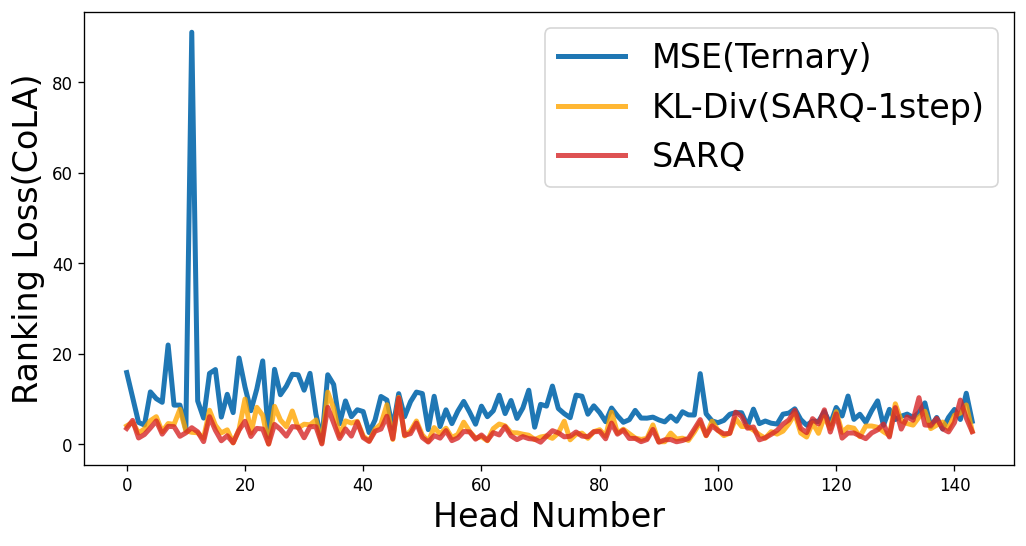

In [493]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=120)
fs=20
lw=3
ax.plot(list(range(layer_num*head_num)), st_1, label="MSE(Ternary)", color="tab:blue", linewidth=lw, alpha=1)
ax.plot(list(range(layer_num*head_num)), st_2, label="KL-Div(SARQ-1step)", color="orange", linewidth=lw, alpha=0.8)
ax.plot(list(range(layer_num*head_num)), st_3, label="SARQ", color="tab:red", linewidth=lw, alpha=0.8)

ax.legend(fontsize=fs, loc=1)
ax.set_xlabel("Head Number", fontsize=fs)
ax.set_ylabel(f"Ranking Loss(CoLA)", fontsize=fs)


In [322]:
magic_number = 3

In [323]:


ranking_dict = dict()
tc_ratio_dict = dict()
st_ratio_dict_1 = dict()
st_ratio_dict_2 = dict()
q_ratio_dict = dict()

for l in range(layer_num):
    for h in range(head_num):
        ranking_dict[f"{l}_{h}"] = []
        tc_ratio_dict[f"{l}_{h}"] = []
        st_ratio_dict_1[f"{l}_{h}"] = []
        st_ratio_dict_2[f"{l}_{h}"] = []
        q_ratio_dict[f"{l}_{h}"] = []

for l in range(layer_num):
    for h in range(head_num):
        token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_tc = torch.sort(token_avg_tc, stable=True, descending=True)[1].clone().detach()    
        ranking_dict[f"{l}_{h}"].append(token_order_tc[:magic_number])

        

In [324]:
for l in range(layer_num):
    for h in range(head_num):
        token_avg_tc = teacher_probs[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_tc = torch.sort(token_avg_tc, stable=True)[1].clone().detach()    
        for token in ranking_dict[f"{l}_{h}"][0]:
            ratio = torch.where(token_order_tc == token)[0] / seq_length
            tc_ratio_dict[f"{l}_{h}"].append(ratio)


for l in range(layer_num):
    for h in range(head_num):
        token_avg_st = student_probs_1[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_st = torch.sort(token_avg_st, stable=True)[1].clone().detach()    
        for token in ranking_dict[f"{l}_{h}"][0]:
            ratio = torch.where(token_order_st == token)[0] / seq_length
            st_ratio_dict_1[f"{l}_{h}"].append(ratio)

for l in range(layer_num):
    for h in range(head_num):
        token_avg_st = student_probs_2[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_st = torch.sort(token_avg_st, stable=True)[1].clone().detach()    
        for token in ranking_dict[f"{l}_{h}"][0]:
            ratio = torch.where(token_order_st == token)[0] / seq_length
            st_ratio_dict_2[f"{l}_{h}"].append(ratio)

for l in range(layer_num):
    for h in range(head_num):
        token_avg_st = q_probs[l][0,h,:,:].mean(dim=0).clone().detach()
        token_order_st = torch.sort(token_avg_st, stable=True)[1].clone().detach()    
        for token in ranking_dict[f"{l}_{h}"][0]:
            ratio = torch.where(token_order_st == token)[0] / seq_length
            q_ratio_dict[f"{l}_{h}"].append(ratio)

In [325]:
tc_ranking = dict()
st_ranking_1 = dict()
st_ranking_2 = dict()
q_ranking = dict()
for i in range(magic_number):
    tc_ranking[f"{i}"] = []
    st_ranking_1[f"{i}"] = []
    st_ranking_2[f"{i}"] = []
    q_ranking[f"{i}"] = []
    

for l in range(layer_num):
    for h in range(head_num):
        for i in range(magic_number):
            tc_ranking[f"{i}"].append(tc_ratio_dict[f"{l}_{h}"][i])
            st_ranking_1[f"{i}"].append(st_ratio_dict_1[f"{l}_{h}"][i])
            st_ranking_2[f"{i}"].append(st_ratio_dict_2[f"{l}_{h}"][i])
            q_ranking[f"{i}"].append(q_ratio_dict[f"{l}_{h}"][i])
        

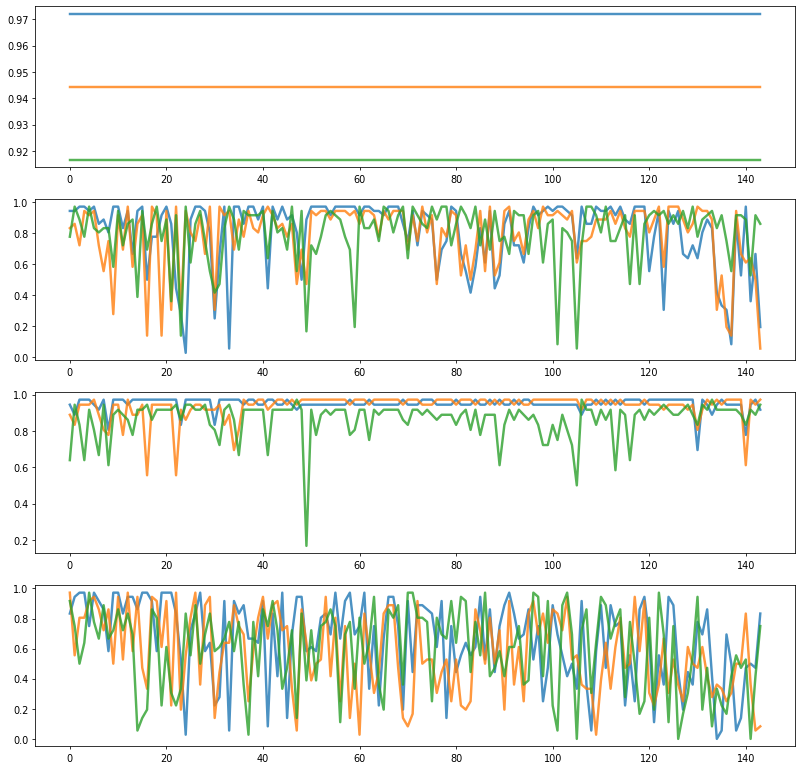

In [326]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(14, 14), dpi=70)

# cl = plt.cm.plasma(np.linspace(0, 1, 3))
# cl = ["plasma", "b", "dodgerblue"]
for i in range(magic_number):
    ax1.plot(list(range(layer_num*head_num)), tc_ranking[f"{i}"], label=f"ranking-{i}", linewidth=2.5, alpha=0.8)
    ax2.plot(list(range(layer_num*head_num)), st_ranking_1[f"{i}"], label=f"ranking-{i}", linewidth=2.5, alpha=0.8)
    ax3.plot(list(range(layer_num*head_num)), st_ranking_2[f"{i}"], label=f"ranking-{i}", linewidth=2.5, alpha=0.8)
    ax4.plot(list(range(layer_num*head_num)), q_ranking[f"{i}"], label=f"ranking-{i}", linewidth=2.5, alpha=0.8)

## Model Evaluation

In [ ]:
eval_st = 1
eval_tc = 1

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=32)

if eval_st:
    print("Student Model Inferece")
    student_model.eval()
    student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
    print(f"Student Result : {student_result}")

if eval_tc:
    print("Teacher Model Inferece")
    teacher_result = do_eval(teacher_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels)
    print(f"Teacher Result : {teacher_result}")
    
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)



In [220]:
# Sampling Sentence 
i = 0 
# num = 
num = 0
for step, batch in enumerate(eval_dataloader):
    model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    i = i + 1
    if i == num:
        break

seq_length = seq_lengths.item()

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)



sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)

input_ids : tensor([[ 101, 2198, 5720, 2000, 3021, 2055, 2370, 1012,  102]])
tokens : ['[CLS]', 'john', 'talked', 'to', 'bill', 'about', 'himself', '.', '[SEP]']
A : john talked to bill about himself . 
B : 
tensor([8])


## BERTViz Model View

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

bertviz_neuron_tc = 1
bertviz_neuron_st = 0
bertviz_model_tc = 0
bertviz_model_st = 0

# Quantization Setting
if bertviz_neuron_st or bertviz_model_st:
    for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, ClipLinear)):    
                module.act_flag = True
                module.weight_flag = True
            if isinstance(module, QuantizeAct):    
                module.act_flag = True
                module.weight_flag = True

if bertviz_neuron_tc or bertviz_neuron_st:
    if bertviz_neuron_st:
        for name, module in student_model.named_modules():
                if isinstance(module, BertSelfAttention):    
                    module.output_bertviz = True
    if bertviz_neuron_tc:
        for name, module in teacher_model.named_modules():
                if isinstance(module, FP_BertSelfAttention):    
                    module.output_bertviz = True

    model_type = 'bert'
    model_version = 'bert-base-uncased'
    
    tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)
    if bertviz_neuron_tc:
        if len(sample_sentence_b) > 1:
            show(teacher_model.cpu(), model_type, tokenizer, sample_sentence_a, sample_sentence_b, display_mode="light")
        else:
            show(teacher_model.cpu(), model_type, tokenizer, sample_sentence_a,display_mode="light")
    if bertviz_neuron_st:
        if len(sample_sentence_b) > 1:
            show(student_model.cpu(), model_type, tokenizer, sample_sentence_a, sample_sentence_b, display_mode="light")
        else:
            show(student_model.cpu(), model_type, tokenizer, sample_sentence_a,display_mode="light")

if bert_size == "large":
    layer_num = 24
    head_num = 16
else:
    layer_num = 12
    head_num = 12
    
all_layers = list(range(layer_num))
layers_to_show = all_layers[20:]

if bertviz_model_tc or bertviz_model_st:
    
    if bertviz_model_tc:
        print("teacher_map")
        for name, module in teacher_model.named_modules():
                    if isinstance(module, FP_BertSelfAttention):    
                        module.output_bertviz = False
        teacher_model.eval()
        teacher_model.to(device)
        teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
        model_view(teacher_probs, tokens, include_layers=layers_to_show,  display_mode="light")
        
    if bertviz_model_st:
        print("student_map")
        for name, module in student_model.named_modules():
                    if isinstance(module, BertSelfAttention):    
                        module.output_bertviz = False
        student_model.eval()
        student_model.to(device)
        student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_outputs=None)
        model_view(student_probs, tokens, sample_sentence_b_start,include_layers=layers_to_show, display_mode="light")# , include_layers=[0, 1])
        
    


In [ ]:
import matplotlib.pyplot as plt
from torch.nn import MSELoss
mse_func = MSELoss()
loss_cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
norm_func = torch.linalg.norm

if bert_size == "large":
    layer_num = 24
    head_num = 16
else:
    layer_num = 12
    head_num = 12

attention_mean_check = 0
cover_mean_check = 0
kl_div_check = 1
mse_check = 0
attnmap_mse_check = 0
norm_check = 0

exclude_sep = 0

for name, module in student_model.named_modules():
            if isinstance(module, BertSelfAttention):    
                module.output_bertviz = False
for name, module in teacher_model.named_modules():
            if isinstance(module, FP_BertSelfAttention):    
                module.output_bertviz = False
                
for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, ClipLinear, QuantizeAct)):    
                module.act_flag = True
                module.weight_flag = True

seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

student_model.eval()
teacher_model.eval()
student_model.to(device)
teacher_model.to(device)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)


if cover_mean_check:
    print("COVER MEAN CHECK")
    top_k = 5

    for i in range(layer_num):
        teacher = teacher_probs[i][0]
        student = student_probs[i][0]

        head_sum = 0
        for h in range(head_num):
            coverage_head_sum = 0
            for row in range(seq_length-1):
                if exclude_sep:
                    tc_argsort = teacher[h][:seq_length-1,:seq_length-1].sort(descending=True)[1][row][:top_k] # top-k
                    st_argsort = student[h][:seq_length-1,:seq_length-1].sort(descending=True)[1][row]
                tc_argsort = teacher[h].sort(descending=True)[1][row][:top_k] # top-k
                st_argsort = student[h].sort(descending=True)[1][row]

                max_idx = 0
                for idx in tc_argsort:
                    tmp = torch.where(st_argsort == idx)
                    max_idx = max(tmp[0].item(), max_idx)

                coverage_ratio = max_idx / student.shape[1]
                coverage_head_sum += coverage_ratio

                # print(f"H{h} : {coverage_head_sum/seq_length}")

            head_sum += coverage_head_sum / seq_length
        print(head_sum / head_num)

if kl_div_check:
    print("KL DIV CHECK")
    for i in range(layer_num):
        if exclude_sep:
            if len(sep_index) == 2:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000; teacher_atts[i][:,:,:,sep_index[1]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000; student_atts[i][:,:,:,sep_index[1]] = -100000
            else:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000
                
            teacher = torch.nn.Softmax(dim=-1)(teacher_atts[i])
            student = torch.nn.Softmax(dim=-1)(student_atts[i])
            
            student = torch.clamp_min(student, 1e-8)
            teacher = torch.clamp_min(teacher, 1e-8)
        else:    
            teacher = teacher_probs[i]
            student = student_probs[i]
        
        neg_cross_entropy = teacher * torch.log(student) 
        neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
        neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

        # p(t) log p(t) = negative entropy
        neg_entropy = teacher * torch.log(teacher) 
        neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)
        neg_entropy = torch.sum(neg_entropy, dim=-1) / seq_lengths.view(-1, 1)  # (b, h, s) -> (b, h)

        kld_loss = neg_entropy - neg_cross_entropy

        kld_loss_sum = torch.sum(kld_loss)
        print(kld_loss_sum.item())

if mse_check:
    for i in range(layer_num):
        print(mse_func(teacher_atts[i], student_atts[i]).item())
        
if attnmap_mse_check:
    for i in range(layer_num):
        if exclude_sep:
            if len(sep_index) == 2:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000; teacher_atts[i][:,:,:,sep_index[1]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000; student_atts[i][:,:,:,sep_index[1]] = -100000
            else:
                teacher_atts[i][:,:,:,sep_index[0]] = -100000
                student_atts[i][:,:,:,sep_index[0]] = -100000
                
            teacher = torch.nn.Softmax(dim=-1)(teacher_atts[i])
            student = torch.nn.Softmax(dim=-1)(student_atts[i])
            print(mse_func(teacher, student).item())
        else:    
            print(mse_func(teacher_probs[i], student_probs[i]).item())

if norm_check:
    for i in range(layer_num):
        print(mse_func(torch.linalg.norm(teacher_values[i], dim=-1), torch.linalg.norm(student_values[i], dim=-1)).mean().item())
        # print(loss_cos(teacher_values[i], student_values[i]).mean().item())
    

## Norm-Weight Analysis

In [ ]:
import matplotlib.pyplot as plt
from torch.nn import MSELoss
mse_func = MSELoss()
loss_cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
norm_func = torch.linalg.norm

if bert_size == "large":
    layer_num = 24
    head_num = 16
else:
    layer_num = 12
    head_num = 12
    
sep_w_list = [ AverageMeter() for i in range(layer_num) ]; cls_w_list = [ AverageMeter() for i in range(layer_num) ] ;punc_w_list = [ AverageMeter() for i in range(layer_num) ] ;other_w_list = [ AverageMeter() for i in range(layer_num) ]
sep_n_list = [ AverageMeter() for i in range(layer_num) ]; cls_n_list = [ AverageMeter() for i in range(layer_num) ] ;punc_n_list = [ AverageMeter() for i in range(layer_num) ] ;other_n_list = [ AverageMeter() for i in range(layer_num) ]
sep_v_list = [ AverageMeter() for i in range(layer_num) ]; cls_v_list = [ AverageMeter() for i in range(layer_num) ] ;punc_v_list = [ AverageMeter() for i in range(layer_num) ] ;other_v_list = [ AverageMeter() for i in range(layer_num) ]



for batch in tqdm(eval_dataloader, desc="Inference"):
    model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    seq_length = seq_lengths.item()
    input_ids_sliced = input_ids[:,:seq_length]
    sep_index = torch.where(input_ids[0] == 102)[0]
    
    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

    probs = student_probs
    values = student_values
    
#     probs = teacher_probs
#     values = teacher_values
    
   
    

    for i in range(layer_num):
        # Attention Weight Analysis
        if len(sep_index) == 2:
            sep_w = (probs[i][0,:,:,sep_index[0]].mean() + probs[i][0,:,:,sep_index[1]].mean() / 2).item()
            punc_w = (probs[i][0,:,:,sep_index[0] - 1].mean() + probs[i][0,:,:,sep_index[1] - 1].mean() / 2).item()
            sep_w_list[i].update(sep_w)
            punc_w_list[i].update(punc_w)
        else:
            sep_w = probs[i][0,:,:,sep_index[0]].mean().item()
            punc_w = probs[i][0,:,:,sep_index[0]-1].mean().item()
            sep_w_list[i].update(sep_w)
            punc_w_list[i].update(punc_w)
        cls_w = probs[i][0,:,:,0].mean().item()
        cls_w_list[i].update(cls_w)
        other_w_list[i].update(1 - (sep_w + punc_w + cls_w))

        # Attention Norm based Analysis (|| alpha f(x) ||)
        if len(sep_index) == 2:
            sep_n = (norm_func(values[i][0][0,:,sep_index[0],:], dim=-1).mean() + norm_func(values[i][0][0,:,sep_index[1],:], dim=-1).mean() / 2).item()
            punc_n = (norm_func(values[i][0][0,:,sep_index[0] - 1,:], dim=-1).mean() + norm_func(values[i][0][0,:,sep_index[1] - 1,:], dim=-1).mean() / 2).item()
            sep_n_list[i].update(sep_n)
            punc_n_list[i].update(punc_n)
        else:
            sep_n = norm_func(values[i][0][0,:,sep_index[0],:], dim=-1).mean().item()
            punc_n = norm_func(values[i][0][0,:,sep_index[0]-1,:], dim=-1).mean().item()
            sep_n_list[i].update(sep_n)
            punc_n_list[i].update(punc_n)

        cls_n = norm_func(values[i][0][0,:,0,:], dim=-1).mean().item()
        cls_n_list[i].update(cls_n)
        
        values[i][0][0,:,sep_index[0],:] = 0
        if len(sep_index) == 2:
            values[i][0][0,:,sep_index[1],:] = 0
            
        values[i][0][0,:,sep_index[0] - 1,:] = 0
        if len(sep_index) == 2:
            values[i][0][0,:,sep_index[1] - 1,:] = 0
        
        values[i][0][0,:,0,:] = 0

        shape = values[i][0][0,:,:,:].shape
        if len(sep_index) == 2:
            num = shape[0] * (shape[1] - 5)
        else:
            num = shape[0] * (shape[1] - 3)

        other_n = (norm_func(values[i][1][0,:,:,:], dim=-1).sum() / num).item()
        other_n_list[i].update(other_n)

        # Attention Norm based Analysis (|| f(x) ||)
        if len(sep_index) == 2:
            sep_v_list[i].update((norm_func(values[i][1][0,:,sep_index[0],:], dim=-1).mean() + norm_func(values[i][1][0,:,sep_index[1],:], dim=-1).mean() / 2).item())
            punc_v_list[i].update((norm_func(values[i][1][0,:,sep_index[0] - 1,:], dim=-1).mean() + norm_func(values[i][1][0,:,sep_index[1] - 1,:], dim=-1).mean() / 2).item())
        else:
            sep_v_list[i].update(norm_func(values[i][1][0,:,sep_index[0],:], dim=-1).mean().item())
            punc_v_list[i].update(norm_func(values[i][1][0,:,sep_index[0]-1,:], dim=-1).mean().item())
        cls_v_list[i].update(norm_func(values[i][1][0,:,0,:], dim=-1).mean().item())

        values[i][1][0,:,sep_index[0],:] = 0
        if len(sep_index) == 2:
            values[i][1][0,:,sep_index[1],:] = 0
        
        values[i][1][0,:,sep_index[0] - 1,:] = 0
        if len(sep_index) == 2:
            values[i][1][0,:,sep_index[1] - 1,:] = 0
        values[i][1][0,:,0,:] = 0

        shape = values[i][1][0,:,:,:].shape
        if len(sep_index) == 2:
            num = shape[0] * (shape[1] - 5)
        else:
            num = shape[0] * (shape[1] - 3)

        other_v_list[i].update((norm_func(values[i][1][0,:,:,:], dim=-1).sum() / num).item())
    


In [ ]:
l_sep_w_list = list(); l_cls_w_list = list() ;l_punc_w_list = list() ;l_other_w_list = list()
l_sep_n_list = list(); l_cls_n_list = list() ;l_punc_n_list = list() ;l_other_n_list = list()
l_sep_v_list = list(); l_cls_v_list = list() ;l_punc_v_list = list() ;l_other_v_list = list()

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(12,16))            
x_axis = list(range(layer_num))

for layer in range(layer_num):
    l_sep_w_list.append(sep_w_list[layer].avg); l_sep_n_list.append(sep_n_list[layer].avg); l_sep_v_list.append(sep_v_list[layer].avg)
    l_cls_w_list.append(cls_w_list[layer].avg); l_cls_n_list.append(cls_n_list[layer].avg); l_cls_v_list.append(cls_v_list[layer].avg)
    l_punc_w_list.append(punc_w_list[layer].avg); l_punc_n_list.append(punc_n_list[layer].avg); l_punc_v_list.append(punc_v_list[layer].avg)
    l_other_w_list.append(other_w_list[layer].avg); l_other_n_list.append(other_n_list[layer].avg); l_other_v_list.append(other_v_list[layer].avg) 

ax1.set_title("Attention Weight-based Analysis")
ax1.plot(x_axis, l_sep_w_list, label="SEP", linewidth=3)
ax1.plot(x_axis, l_cls_w_list, label="CLS", linewidth=3)
ax1.plot(x_axis, l_punc_w_list, label=". or ,", linewidth=3)
ax1.plot(x_axis, l_other_w_list, label="Other", linewidth=3)
ax1.legend()

ax2.set_title("Attention Norm-based Analysis")
ax2.plot(x_axis, l_sep_n_list, label="SEP", linewidth=3)
ax2.plot(x_axis, l_cls_n_list, label="CLS", linewidth=3)
ax2.plot(x_axis, l_punc_n_list, label=". or ,", linewidth=3)
ax2.plot(x_axis, l_other_n_list, label="Other", linewidth=3)
ax2.legend()

ax3.set_title("Attention Value-Norm-based Analysis")
ax3.plot(x_axis, l_sep_v_list, label="SEP", linewidth=3)
ax3.plot(x_axis, l_cls_v_list, label="CLS", linewidth=3)
ax3.plot(x_axis, l_punc_v_list, label=". or ,", linewidth=3)
ax3.plot(x_axis, l_other_v_list, label="Other", linewidth=3)
ax3.legend()

plt.show()

### Weight - Norm Based Analysis

In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

student_model.eval()
teacher_model.eval()
student_model.to(device)
teacher_model.to(device)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)


probs = student_probs
values = student_values
# probs = teacher_probs
# values = teacher_values

table_sep = [[0] * head_num for i in range(layer_num)]
table_cls = [[0] * head_num for i in range(layer_num)]
table_punc = [[0] * head_num for i in range(layer_num)]
table_other = [[0] * head_num for i in range(layer_num)]

for l in range(layer_num):
    for h in range(head_num):        
        prob_sep = ((probs[l][:,h,:,sep_index[0]].mean() + probs[l][:,h,:,sep_index[1]].mean())/2).item()
        table_sep[l][h] = prob_sep
        prob_cls = probs[l][:,h,:,0].mean().item()
        table_cls[l][h] = prob_cls
        prob_punc = ((probs[l][:,h,:,sep_index[0]-1].mean() + probs[l][:,h,:,sep_index[1]-1].mean())/2).item()
        table_punc[l][h] = prob_punc
#         prob_other = 1 - (prob_sep + prob_sep + prob_punc)
#         table_other[l][h] = prob_other

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))
ax1.set_xlabel("head", fontsize=30); ax1.set_ylabel("layer", fontsize=30)
# ax1.set_title("SEP Probability AVG")
heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax1)

ax2.set_xlabel("head", fontsize=36); ax2.set_ylabel("layer", fontsize=36)
# ax2.set_title("CLS Probability AVG")
heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax2)

ax3.set_xlabel("head", fontsize=36); ax3.set_ylabel("layer", fontsize=36)
# ax3.set_title("PUNC Probability AVG")
heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax3)
plt.show()
# ax4.set_xlabel("head"); ax1.set_ylabel("layer")
# ax4.set_title("Other Probability AVG")
# heatmap = ax4.pcolor(table_other, cmap=plt.cm.Blues)


norm_type = 0 # 0 : f(x) 1 : p*f(x)
table_sep = [[0] * head_num for i in range(layer_num)]
table_cls = [[0] * head_num for i in range(layer_num)]
table_punc = [[0] * head_num for i in range(layer_num)]
# table_other = [[0] * head_num for i in range(layer_num)]

for l in range(layer_num):
    for h in range(head_num):        
        norm_sep = (norm_func(values[l][norm_type][0,h,sep_index[0],:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1],:], dim=-1).mean() / 2).item()
        table_sep[l][h] = norm_sep
        norm_cls = norm_func(values[l][norm_type][0,h,0,:], dim=-1).mean().item()
        table_cls[l][h] = norm_cls
        norm_punc = (norm_func(values[l][norm_type][0,h,sep_index[0] - 1,:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1] - 1,:], dim=-1).mean() / 2).item()
        table_punc[l][h] = norm_punc
#         prob_other = 1 - (prob_sep + prob_sep + prob_punc)
#         table_other[l][h] = prob_other

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))
# fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax1.set_xlabel("head", fontsize = 28); ax.set_ylabel("layer", fontsize = 28)
ax1.set_title("SEP ||f(x)|| Norm AVG")
heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)
# fig.savefig("2SB.png")
fig.colorbar(heatmap, ax=ax1)

ax2.set_xlabel("head", fontsize = 28); ax2.set_ylabel("layer", fontsize = 28)
ax2.set_title("CLS ||f(x)|| Norm AVG")
heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax2)

ax3.set_xlabel("head"); ax1.set_ylabel("layer")
ax3.set_title("PUNC ||f(x)|| Norm AVG")
heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax3)
plt.show()


norm_type = 1 # 0 : f(x) 1 : p*f(x)
table_sep = [[0] * head_num for i in range(layer_num)]
table_cls = [[0] * head_num for i in range(layer_num)]
table_punc = [[0] * head_num for i in range(layer_num)]
# table_other = [[0] * head_num for i in range(layer_num)]

for l in range(layer_num):
    for h in range(head_num):        
        norm_sep = (norm_func(values[l][norm_type][0,h,sep_index[0],:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1],:], dim=-1).mean() / 2).item()
        table_sep[l][h] = norm_sep
        norm_cls = norm_func(values[l][norm_type][0,h,0,:], dim=-1).mean().item()
        table_cls[l][h] = norm_cls
        norm_punc = (norm_func(values[l][norm_type][0,h,sep_index[0] - 1,:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1] - 1,:], dim=-1).mean() / 2).item()
        table_punc[l][h] = norm_punc
#         prob_other = 1 - (prob_sep + prob_sep + prob_punc)
#         table_other[l][h] = prob_other

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))
ax1.set_xlabel("head"); ax1.set_ylabel("layer")
ax1.set_title("SEP ||p*f(x)|| Norm AVG")
heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax1)

ax2.set_xlabel("head"); ax1.set_ylabel("layer")
ax2.set_title("CLS ||p*f(x)|| Norm AVG")
heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax2)

ax3.set_xlabel("head"); ax1.set_ylabel("layer")
ax3.set_title("PUNC ||p*f(x)|| Norm AVG")
heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax3)
plt.show()
# ax4.set_xlabel("head"); ax1.set_ylabel("layer")
# ax4.set_title("Other Probability AVG")
# heatmap = ax4.pcolor(table_other, cmap=plt.cm.Blues)

### Norm Based Cosine Similarity Comparison

In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

student_model.eval()
teacher_model.eval()
student_model.to(device)
teacher_model.to(device)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

st_values = student_values
tc_values = teacher_values

loss_cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

norm_type = 0 # 0 : f(x) 1 : p*f(x)

table_sep = [[0] * head_num for i in range(layer_num)]
table_cls = [[0] * head_num for i in range(layer_num)]
table_punc = [[0] * head_num for i in range(layer_num)]

for l in range(layer_num):
    for h in range(head_num): 
        # cos_sep_1 = loss_cos(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
        # cos_sep_2 = loss_cos(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
        cos_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
        cos_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
        # table_sep[l][h] = (1-((cos_sep_1 + cos_sep_2) / 2)).item()
        table_sep[l][h] = ((cos_sep_1 + cos_sep_2) / 2).item()
        
        # cos_cls = loss_cos(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
        cos_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
        # table_cls[l][h] = (1-cos_cls).item()
        table_cls[l][h] = (cos_cls).item()
        
        # cos_punc_1 = loss_cos(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:]) 
        # cos_punc_2 = loss_cos(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
        cos_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:]) 
        cos_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
        # table_punc[l][h] = (1-((cos_sep_1 + cos_sep_2) / 2)).item()
        table_punc[l][h] = ((cos_sep_1 + cos_sep_2) / 2).item()

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))
ax1.set_xlabel("head"); ax1.set_ylabel("layer")
ax1.set_title("SEP Cosine Similarity w/ Teacher")
heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax1)

ax2.set_xlabel("head"); ax1.set_ylabel("layer")
ax2.set_title("CLS Cosine Similarity w/ Teacher")
heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax2)

ax3.set_xlabel("head"); ax1.set_ylabel("layer")
ax3.set_title("PUNC Cosine Similarity w/ Teacher")
heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax3)
# plt.show()





In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

student_model.eval()
teacher_model.eval()
student_model.to(device)
teacher_model.to(device)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

st_values = student_values
tc_values = teacher_values

loss_cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)

norm_type = 1 # 0 : f(x) 1 : p*f(x)

table_sep = [[0] * head_num for i in range(layer_num)]
table_cls = [[0] * head_num for i in range(layer_num)]
table_punc = [[0] * head_num for i in range(layer_num)]

for l in range(layer_num):
    for h in range(head_num): 
        cos_sep_1 = loss_cos(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
        cos_sep_2 = loss_cos(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:])         
        table_sep[l][h] = (1-((cos_sep_1 + cos_sep_2) / 2)).item()
        
        cos_cls = loss_cos(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
        table_cls[l][h] = (1-cos_cls).item()
        
        cos_punc_1 = loss_cos(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:]) 
        cos_punc_2 = loss_cos(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:])         
        table_punc[l][h] = (1-((cos_sep_1 + cos_sep_2) / 2)).item()

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(32,8))
ax1.set_xlabel("head"); ax1.set_ylabel("layer")
ax1.set_title("SEP Cosine Similarity w/ Teacher")
heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax1)

ax2.set_xlabel("head"); ax1.set_ylabel("layer")
ax2.set_title("CLS Cosine Similarity w/ Teacher")
heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax2)

ax3.set_xlabel("head"); ax1.set_ylabel("layer")
ax3.set_title("PUNC Cosine Similarity w/ Teacher")
heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
fig.colorbar(heatmap, ax=ax3)
plt.show()

# # ax4.set_xlabel("head"); ax1.set_ylabel("layer")
# # ax4.set_title("Other Probability AVG")
# # heatmap = ax4.pcolor(table_other, cmap=plt.cm.Blues)

# norm_type = 1 # 0 : f(x) 1 : p*f(x)
# table_sep = [[0] * head_num for i in range(layer_num)]
# table_cls = [[0] * head_num for i in range(layer_num)]
# table_punc = [[0] * head_num for i in range(layer_num)]
# # table_other = [[0] * head_num for i in range(layer_num)]

# for l in range(layer_num):
#     for h in range(head_num):        
#         norm_sep = (norm_func(values[l][norm_type][0,h,sep_index[0],:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1],:], dim=-1).mean() / 2).item()
#         table_sep[l][h] = norm_sep
#         norm_cls = norm_func(values[l][norm_type][0,h,0,:], dim=-1).mean().item()
#         table_cls[l][h] = norm_cls
#         norm_punc = (norm_func(values[l][norm_type][0,h,sep_index[0] - 1,:], dim=-1).mean() + norm_func(values[l][norm_type][0,h,sep_index[1] - 1,:], dim=-1).mean() / 2).item()
#         table_punc[l][h] = norm_punc
# #         prob_other = 1 - (prob_sep + prob_sep + prob_punc)
# #         table_other[l][h] = prob_other

# fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(24,8))
# ax1.set_xlabel("head"); ax1.set_ylabel("layer")
# ax1.set_title("SEP ||p*f(x)|| Norm AVG")
# heatmap = ax1.pcolor(table_sep, cmap=plt.cm.Blues)

# ax2.set_xlabel("head"); ax1.set_ylabel("layer")
# ax2.set_title("CLS ||p*f(x)|| Norm AVG")
# heatmap = ax2.pcolor(table_cls, cmap=plt.cm.Blues)

# ax3.set_xlabel("head"); ax1.set_ylabel("layer")
# ax3.set_title("PUNC ||p*f(x)|| Norm AVG")
# heatmap = ax3.pcolor(table_punc, cmap=plt.cm.Blues)
# plt.show()
# # ax4.set_xlabel("head"); ax1.set_ylabel("layer")
# # ax4.set_title("Other Probability AVG")
# # heatmap = ax4.pcolor(table_other, cmap=plt.cm.Blues)

In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

norm_type = 0 # 1 : f(x) 0 : p*f(x)

student_model.eval()
teacher_model.eval()
student_model.to(device)
teacher_model.to(device)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)


        
#         diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#         diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
#         sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
        
#         diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
#         cls_list.append((diff_cls).item())
        
#         diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#         diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
#         punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
        
#         st_values[l][norm_type][0,h,sep_index[0],:] = 0
#         tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
#         st_values[l][norm_type][0,h,sep_index[1],:] = 0
#         tc_values[l][norm_type][0,h,sep_index[1],:] = 0
        
#         st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#         tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
#         st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#         tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
        
#         st_values[l][norm_type][0,h,0,:] = 0
#         tc_values[l][norm_type][0,h,0,:] = 0
        
        # diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
        # other_list.append(diff_other.item())

        


In [ ]:
ternary_prob_kl = kld_list

In [ ]:
sarq_c_prob_kl = kld_list

In [ ]:
sarq_prob_kl = kld_list

In [ ]:
eval_st = 1
eval_tc = 0

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=32)

if eval_st:
    print("Student Model Inferece")
    student_model.eval()
    student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
    print(f"Student Result : {student_result}")

if eval_tc:
    print("Teacher Model Inferece")
    teacher_result = do_eval(teacher_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels)
    print(f"Teacher Result : {teacher_result}")
    
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)



In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)

# st_model_name = "ternary_save"
# st_model_name = "step_2_context"
# st_model_name = "step_2_output"
# st_model_name = "step_2"
# st_model_name = "sarq_step1"



build_tc = 1
build_st = 1

if build_tc:
    # Teacher Model Build
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()
    model = teacher_model
    
for st_model_name in ["1SB_S", "1SB_S_M", "step_2_S_M"]:
    student_model_dir = os.path.join(output_dir, task_name, "exploration", st_model_name)   

    if build_st:
        # Student Model Build
        student_config = BertConfig.from_pretrained(student_model_dir
#                                                         quantize_act=True,
#                                                         quantize_weight=True,
#                                                         weight_bits = 2, # Always Ternary when "quantize_weight = True"
#                                                         input_bits = 8,
#                                                         clip_val = 2.5,
#                                                         quantize = True,
#                                                         ffn_q_1 = True,
#                                                         ffn_q_2 = True,
#                                                         qkv_q = True,
#                                                         emb_q = True,
#                                                         cls_q = True,
#                                                         clipping = False,
#                                                         layer_num = -1,
#                                                         mean_scale = 0.7,
#                                                         quantizer = "ternary",
#                                                         act_quantizer = "ternary",
#                                                         init_scaling = 1,
#                                                         clip_ratio = 1,
#                                                         gradient_scaling = False,
#                                                         clip_method = "minmax",
#                                                         teacher_attnmap = False,
#                                                         parks = False,
#                                                         stop_grad = False,
#                                                         qk_FP = True,
#                                                         map=False,
#                                                         act_method = "clipping"
                                                        )

        student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
        student_model.to(device)
        model = student_model
        print()

        # Quantization Option ACT/WEIGHT
        for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
                module.act_flag = True
                module.weight_flag = True

    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device))
    logits, loss, cls_loss, rep_loss, output_loss, attmap_loss, attscore_loss, coeff_list, student_zip = student_model(input_ids_sliced.to(device), teacher_outputs=None)
    
    
    kld_list = []

    student_probs = student_zip[1]
    kl_loss = torch.nn.KLDivLoss(reduction="sum")

    for l in range(layer_num):
        for h in range(head_num): 
            student = student_probs[l][0,h,:,:]
            teacher = teacher_probs[l][0,h,:,:]
            neg_cross_entropy = teacher * torch.log(student) 
            neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)


            # p(t) log p(t) = negative entropy
            neg_entropy = teacher * torch.log(teacher) 
            neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)

            kl_div = neg_entropy - neg_cross_entropy
            # print(kl_div.mean().item())
            kld_list.append(kl_div.mean().item())
     
    if st_model_name == "1SB_S":
        print(st_model_name)
        t_kld_list = kld_list
    elif st_model_name == "1SB_S_M":
        print(st_model_name)    
        s_kld_list = kld_list
    elif st_model_name == "step_2_S_M":
        print(st_model_name)
        sc_kld_list = kld_list 
    
    
    
    
    # (layer_context, attention_output, value_layer, self_output_hs)
    st_values = student_zip[0]
    tc_values = teacher_zip

    norm_type = 2 

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []

    for l in range(layer_num):
        for h in range(head_num): 

            if len(sep_index) == 2:
                diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
                sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
            else:
                diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                sep_list.append(diff_sep.item())

            diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
            cls_list.append((diff_cls).item())

            if len(sep_index) == 2:
                diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
                punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
            else:
                diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                punc_list.append((diff_punc).item())

            if len(sep_index) == 2:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
                st_values[l][norm_type][0,h,sep_index[1],:] = 0
                tc_values[l][norm_type][0,h,sep_index[1],:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

            if len(sep_index) == 2:        
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
                st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

            st_values[l][norm_type][0,h,0,:] = 0
            tc_values[l][norm_type][0,h,0,:] = 0

            diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
            other_list.append(diff_other.item())


    if st_model_name == "1SB_S":
        print(st_model_name)
        v_t_sep = sep_list 
        v_t_cls = cls_list 
        v_t_punc = punc_list 
        v_t_other = other_list 
    elif st_model_name == "1SB_S_M":
        print(st_model_name)    
        v_s_sep = sep_list 
        v_s_cls = cls_list 
        v_s_punc = punc_list 
        v_s_other = other_list 
    elif st_model_name == "step_2_S_M":
        print(st_model_name)
        v_sc_sep = sep_list 
        v_sc_cls = cls_list 
        v_sc_punc = punc_list 
        v_sc_other = other_list         
    elif st_model_name == "step_2_output" or st_model_name == "sarq_step1": 
        print(st_model_name)
        v_so_sep = sep_list 
        v_so_cls = cls_list 
        v_so_punc = punc_list 
        v_so_other = other_list   

    norm_type = 0 # 1 : Attention Output 0 : Layer Context

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []

    tokens
#     for l in range(layer_num):
#         if len(sep_index) == 2:
#             diff_sep_1 = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
#             diff_sep_2 = mse_func(st_values[l][norm_type][0,sep_index[1],:], tc_values[l][norm_type][0,sep_index[1],:]) 
#             sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
#         else:
#             diff_sep = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
#             sep_list.append(diff_sep.item())

#         diff_cls = mse_func(st_values[l][norm_type][0,0,:], tc_values[l][norm_type][0,0,:])
#         cls_list.append((diff_cls).item())

#         if len(sep_index) == 2:
#             diff_punc_1 = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
#             diff_punc_2 = mse_func(st_values[l][norm_type][0,sep_index[1]-1,:], tc_values[l][norm_type][0,sep_index[1]-1,:]) 
#             punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
#         else:
#             diff_punc = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
#             punc_list.append((diff_punc).item())

#         if len(sep_index) == 2:
#             st_values[l][norm_type][0,sep_index[0],:] = 0
#             tc_values[l][norm_type][0,sep_index[0],:] = 0        
#             st_values[l][norm_type][0,sep_index[1],:] = 0
#             tc_values[l][norm_type][0,sep_index[1],:] = 0
#         else:
#             st_values[l][norm_type][0,sep_index[0],:] = 0
#             tc_values[l][norm_type][0,sep_index[0],:] = 0        

#         if len(sep_index) == 2:        
#             st_values[l][norm_type][0,sep_index[0]-1,:] = 0
#             tc_values[l][norm_type][0,sep_index[0]-1,:] = 0        
#             st_values[l][norm_type][0,sep_index[1]-1,:] = 0
#             tc_values[l][norm_type][0,sep_index[1]-1,:] = 0
#         else:
#             st_values[l][norm_type][0,sep_index[0]-1,:] = 0
#             tc_values[l][norm_type][0,sep_index[0]-1,:] = 0

#         st_values[l][norm_type][0,0,:] = 0
#         tc_values[l][norm_type][0,0,:] = 0

#         diff_other = mse_func(st_values[l][norm_type][0,:,:], tc_values[l][norm_type][0,:,:])
#         other_list.append(diff_other.item())

    for l in range(layer_num):
        for h in range(head_num): 

            if len(sep_index) == 2:
                diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
                sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
            else:
                diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                sep_list.append(diff_sep.item())

            diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
            cls_list.append((diff_cls).item())

            if len(sep_index) == 2:
                diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
                punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
            else:
                diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                punc_list.append((diff_punc).item())

            if len(sep_index) == 2:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
                st_values[l][norm_type][0,h,sep_index[1],:] = 0
                tc_values[l][norm_type][0,h,sep_index[1],:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

            if len(sep_index) == 2:        
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
                st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

            st_values[l][norm_type][0,h,0,:] = 0
            tc_values[l][norm_type][0,h,0,:] = 0

            diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
            other_list.append(diff_other.item())

    if st_model_name == "1SB_S":
        print(st_model_name)
        vw_t_sep = sep_list 
        vw_t_cls = cls_list 
        vw_t_punc = punc_list 
        vw_t_other = other_list 
    elif st_model_name == "1SB_S_M":
        print(st_model_name)
        vw_s_sep = sep_list 
        vw_s_cls = cls_list 
        vw_s_punc = punc_list 
        vw_s_other = other_list 
    elif st_model_name == "step_2_S_M":
        print(st_model_name)
        vw_sc_sep = sep_list 
        vw_sc_cls = cls_list 
        vw_sc_punc = punc_list 
        vw_sc_other = other_list   
    elif st_model_name == "step_2_output" or st_model_name == "sarq_step1": 
        print(st_model_name)
        vw_so_sep = sep_list 
        vw_so_cls = cls_list 
        vw_so_punc = punc_list 
        vw_so_other = other_list   


In [ ]:
st_values[0][0].shape

In [ ]:
import matplotlib.ticker as mtick
fig, ax2 = plt.subplots(1,1, figsize=(8, 5.5), dpi=70)
plt.rcParams['axes.linewidth'] = 2.2
plt.rcParams['patch.linewidth'] = 2.2

font_size = 23
line_w =1.5

x_axis_num = layer_num * head_num

# ax1.plot(list(range(x_axis_num)),v_t_cls, label="Ternary", color='r', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),v_sc_cls, label="SARQ-1step", color='c', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),v_s_cls, label="SARQ", color='b', linewidth=line_w)
# # ax1.plot(list(range(x_axis_num)),v_so_cls, label="SARQ_O", color='tab:orange', linewidth=line_w)
# ax1.tick_params(axis="x", labelsize=font_size)
# ax1.tick_params(axis="y", labelsize=font_size)
# ax1.legend(fontsize=font_size, loc=1)
# ax1.set_ylabel("MSE", fontsize=font_size)
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# # ax1.set_title("CLS Value Vector ", fontsize=font_size, fontweight="light")


ax2.plot(list(range(x_axis_num)),v_t_sep, label="Ternary", color='r', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_s_sep, label="SARQ-1step", color='c', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_sc_sep, label="SARQ", color='b', linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),v_so_sep, label="SARQ_O", color='tab:orange', linewidth=line_w)

ax2.legend(fontsize=font_size, loc=1)
ax2.set_xlabel("Head", fontsize=font_size)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# ax2.set_title("SEP Value Vector ", fontsize=font_size, fontweight="light")
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)

# ax3.plot(list(range(x_axis_num)),v_t_punc, label="Ternary", color='r', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),v_s_punc, label="SARQ-1step", color='c', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),v_sc_punc, label="SARQ_C", color='b', linewidth=line_w)
# # ax3.plot(list(range(x_axis_num)),v_so_punc, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax3.legend(fontsize=font_size, loc=1)
# ax3.set_ylabel("MSE", fontsize=font_size)
# ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# # ax3.set_title("PUNC Value Vector ", fontsize=font_size, fontweight="light")

# ax4.plot(list(range(x_axis_num)),v_t_other, label="Ternary", color='r', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),v_s_other, label="SARQ-1step", color='c', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),v_sc_other, label="SARQ", color='b', linewidth=line_w)
# # ax4.plot(list(range(x_axis_num)),v_so_other, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax4.legend(fontsize=font_size, loc=1)
# ax4.set_ylabel("MSE", fontsize=font_size)
# ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
# # ax4.set_title("Other Value Vector ", fontsize=font_size, fontweight="light")
plt.show()

print("=====================================================================================================================")

fig, ax2 = plt.subplots(1,1, figsize=(8, 5.5), dpi=70)

x_axis_num = layer_num * head_num

# ax1.plot(list(range(x_axis_num)),vw_t_cls, label="Ternary", color='r', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_s_cls, label="SARQ-1step", color='c', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_sc_cls, label="SARQ", color='b', linewidth=line_w)
# # ax1.plot(list(range(x_axis_num)),vw_so_cls, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax1.legend(fontsize=font_size, loc=1)
# ax1.set_ylabel("MSE", fontsize=font_size)
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# # ax1.set_title("CLS LN Output Vector ", fontsize=font_size, fontweight="light")


ax2.plot(list(range(x_axis_num)),vw_t_sep, label="Ternary", color='r', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_s_sep, label="SARQ-1step", color='c', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_sc_sep, label="SARQ", color='b', linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),vw_so_sep, label="SARQ_O", color='tab:orange', linewidth=line_w)

ax2.legend(fontsize=font_size, loc=1)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.set_xlabel("Head", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax2.set_title("SEP LN Output Vector ", fontsize=font_size, fontweight="light")
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)

# ax3.plot(list(range(x_axis_num)),vw_t_punc, label="Ternary", color='r', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),vw_s_punc, label="SARQ-1step", color='c', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),vw_sc_punc, label="SARQ", color='b', linewidth=line_w)
# # ax3.plot(list(range(x_axis_num)),vw_so_punc, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax3.legend(fontsize=font_size, loc=1)
# ax3.set_ylabel("MSE", fontsize=font_size)
# ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# #x3.set_title("PUNC LN Output Vector ", fontsize=font_size, fontweight="light")

# ax4.plot(list(range(x_axis_num)),vw_t_other, label="Ternary", color='r', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),vw_s_other, label="SARQ-1step", color='c', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),vw_sc_other, label="SARQ", color='b', linewidth=line_w)
#  #ax4.plot(list(range(x_axis_num)),vw_so_other, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax4.legend(fontsize=font_size, loc=1)
# ax4.set_ylabel("MSE", fontsize=font_size)
# ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# # ax4.set_title("Other LN Output Vector ", fontsize=font_size, fontweight="light")
plt.show()

fig, ax2 = plt.subplots(1,1, figsize=(8, 5.5), dpi=70)

x_axis_num = layer_num * head_num

# ax1.plot(list(range(x_axis_num)),vw_t_cls, label="Ternary", color='r', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_s_cls, label="SARQ-1step", color='c', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_sc_cls, label="SARQ", color='b', linewidth=line_w)
# # ax1.plot(list(range(x_axis_num)),vw_so_cls, label="SARQ_O", color='tab:orange', linewidth=line_w)

# ax1.legend(fontsize=font_size, loc=1)
# ax1.set_ylabel("MSE", fontsize=font_size)
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# # ax1.set_title("CLS LN Output Vector ", fontsize=font_size, fontweight="light")


ax2.plot(list(range(x_axis_num)),t_kld_list, label="Ternary", color='r', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),s_kld_list, label="SARQ-1step", color='c', linewidth=line_w)
ax2.plot(list(range(x_axis_num)),sc_kld_list, label="SARQ", color='b', linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),vw_so_sep, label="SARQ_O", color='tab:orange', linewidth=line_w)

ax2.legend(fontsize=font_size, loc=1)
ax2.set_ylabel("KL_Divergence", fontsize=font_size)
ax2.set_xlabel("Head", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax2.set_title("SEP LN Output Vector ", fontsize=font_size, fontweight="light")
ax2.tick_params(axis="x", labelsize=font_size)
ax2.tick_params(axis="y", labelsize=font_size)
# fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(16, 24), dpi=70)

# x_axis_num = layer_num * head_num

# ax1.plot(list(range(x_axis_num)),vw_t_cls, label="Ternary", color='r', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_s_cls, label="SARQ", color='b', linewidth=line_w)
# ax1.plot(list(range(x_axis_num)),vw_sc_cls, label="SARQ_C", color='c', linewidth=line_w)

# ax1.legend(fontsize=font_size, loc=1)
# ax1.set_ylabel("MSE", fontsize=font_size)
# ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax1.set_title("CLS LN Output Vector ", fontsize=font_size, fontweight="light")


# ax2.plot(list(range(x_axis_num)),vw_t_sep, label="Ternary", color='r', linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),vw_s_sep, label="SARQ", color='b', linewidth=line_w)
# ax2.plot(list(range(x_axis_num)),vw_sc_sep, label="SARQ_C", color='c', linewidth=line_w)

# ax2.legend(fontsize=font_size, loc=1)
# ax2.set_ylabel("MSE", fontsize=font_size)
# ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax2.set_title("SEP LN Output Vector ", fontsize=font_size, fontweight="light")

# ax3.plot(list(range(x_axis_num)),vw_t_punc, label="Ternary", color='r', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),vw_s_punc, label="SARQ", color='b', linewidth=line_w)
# ax3.plot(list(range(x_axis_num)),vw_sc_punc, label="SARQ_C", color='c', linewidth=line_w)

# ax3.legend(fontsize=font_size, loc=1)
# ax3.set_ylabel("MSE", fontsize=font_size)
# ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax3.set_title("PUNC LN Output Vector ", fontsize=font_size, fontweight="light")

# ax4.plot(list(range(x_axis_num)),vw_t_other, label="Ternary", color='r', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),vw_s_other, label="SARQ", color='b', linewidth=line_w)
# ax4.plot(list(range(x_axis_num)),vw_sc_other, label="SARQ_C", color='c', linewidth=line_w)

# ax4.legend(fontsize=font_size, loc=1)
# ax4.set_ylabel("MSE", fontsize=font_size)
# ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
# ax4.set_title("Other LN Output Vector ", fontsize=font_size, fontweight="light")
# plt.show()


In [ ]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(12,16), dpi=80)

x_axis_num = layer_num * head_num

ax1.set_title("Period Token")
ax1.plot(list(range(x_axis_num)),t_punc_list, label="Ternary_punc", color='r', linewidth=1)
ax1.plot(list(range(x_axis_num)),SB_punc_list, label="SARQ_punc", color='c', linewidth=1)
ax1.legend(fontsize="12")

ax2.set_title("CLS Token")
ax2.plot(list(range(x_axis_num)),t_cls_list, label="Ternary_cls", color='r', linewidth=1)
ax2.plot(list(range(x_axis_num)),SB_cls_list, label="SARQ_cls", color='c', linewidth=1)
ax2.legend(fontsize="12")

ax3.set_title("SEP Token")
ax3.plot(list(range(x_axis_num)),t_sep_list, label="Ternary_sep", color='r', linewidth=1)
ax3.plot(list(range(x_axis_num)),SB_sep_list, label="SARQ_sep", color='c', linewidth=1)
ax3.legend(fontsize="12")

ax4.set_title("Other Token")
ax4.plot(list(range(x_axis_num)),t_other_list, label="Ternary_other", color='r', linewidth=1)
ax4.plot(list(range(x_axis_num)),SB_other_list, label="SARQ_other", color='c', linewidth=1)
ax4.legend(fontsize="12")

# fig, ax = plt.subplots(1, 1, figsize=(16,8))
# ax.plot(list(range(144)),t_kld_list, label="Ternary_other", color='r', linewidth=1.5)
# ax.plot(list(range(144)),s_kld_list, label="SARQ_other", color='c', linewidth=1.5)
# ax.legend(fontsize="20")

In [ ]:
loss_cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

st_values = student_values
tc_values = teacher_values

loss_cos(st_values[l][norm_type][0,2,sep_index[0],:], tc_values[l][norm_type][0,2,sep_index[0],:])




In [ ]:
a = st_values[l][norm_type][0,2,sep_index[0],:]
b = tc_values[l][norm_type][0,2,sep_index[0],:]

In [ ]:
mse_func(st_values[0][0], tc_values[0][0])

In [ ]:
torch.matmul(a, b) / (norm_func(a) * norm_func(b))